In [1]:
!pip install keras-tuner -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import time
from PIL import Image
import os

from sklearn.metrics import classification_report, confusion_matrix

2024-10-16 04:42:33.445574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 04:42:33.445734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 04:42:33.554084: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 04:42:33.764663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 04:42:35.777189: W tensorflow/compiler/tf2

In [10]:
# !unzip './datasets_benar_coba_upload.zip'
# !unzip './test_data.zip'


Archive:  ./datasets_benar_coba_upload.zip
   creating: datasets_benar_coba_upload/
   creating: datasets_benar_coba_upload/donat/
  inflating: datasets_benar_coba_upload/donat/Donut (115).jpeg  
  inflating: datasets_benar_coba_upload/donat/Donut (98).jpeg  
  inflating: datasets_benar_coba_upload/donat/Donut (148).jpeg  
  inflating: datasets_benar_coba_upload/donat/Donut (19).jpg  
  inflating: datasets_benar_coba_upload/donat/Donut (44).jpeg  
  inflating: datasets_benar_coba_upload/donat/Donut (61).jpeg  
  inflating: datasets_benar_coba_upload/donat/Donut (121).jpeg  
  inflating: datasets_benar_coba_upload/donat/Donut (192).jpeg  
  inflating: datasets_benar_coba_upload/donat/Donut (27).jpeg  
  inflating: datasets_benar_coba_upload/donat/Donut (87).jpeg  
  inflating: datasets_benar_coba_upload/donat/Donut (77).jpeg  
  inflating: datasets_benar_coba_upload/donat/Donut (45).jpg  
  inflating: datasets_benar_coba_upload/donat/Donut (166).jpeg  
  inflating: datasets_benar_coba_u

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [3]:
data_dir = './datasets_benar_coba_upload'
test_dir = './test_data'

In [4]:
"""
 we restrict the maximum inference image size to 480,
as very large images often lead to expensive memory and
training speed overhead

pixel size 300 -> acc 83.2 % di paper efficientNetV2
"""
train_data = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = 16, label_mode = 'categorical', validation_split=0.2,
                                        subset = 'training', seed=42)

val_data = image_dataset_from_directory(data_dir, image_size = (224,224), batch_size = 16, label_mode = 'categorical', validation_split=0.2,
                                        subset = 'validation', seed=42)


Found 11279 files belonging to 55 classes.
Using 9024 files for training.


2024-10-16 04:31:04.051639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 04:31:04.074722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 04:31:04.074888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 11279 files belonging to 55 classes.
Using 2255 files for validation.


In [6]:

img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.40), # 0.4 * 2 * pi
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),
        tf.keras.layers.RandomZoom(.5, .4),
        tf.keras.layers.RandomBrightness(factor=0.2)

    ],
    name='img_augmentation'
)

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

In [8]:
cbCheckpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_keras_dataset.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")
cbEvalAcc =   tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=5, 
    )

In [9]:
epochs=50
learning_rate = 0.0005
decay_rate = learning_rate / 10 *  epochs

def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

lr_rate =  tf.keras.callbacks.LearningRateScheduler(exp_decay)

In [6]:
from tensorflow.keras.applications import EfficientNetV2M
# BASE_MODEL_PATH 
base_model_M = EfficientNetV2M(include_top=False, weights='imagenet', classes=55)
base_model_M.summary()
base_model_M.trainable = False

214201816/214201816 [==============================] - 3s 0us/step
Model: "efficientnetv2-m"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 24)       648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 24)       96        ['stem_conv[0][0]']           
 n)             

In [12]:

"""
coba ganti ke RMSPRop kaya di paper efficientNetv2
RMSProp optimizer with decay 0.9 and
momentum 0.9; batch norm momentum 0.99; weight decay 1e-5. Each model is trained for 350 epochs with total
batch size 4096. Learning rate is first warmed up from 0
to 0.256, and then decayed by 0.97 every 2.4 epochs. We
use exponential moving average with 0.9999 decay rate,
"""
def best_model_EffM():
        inputs = base_model_M.input
        x = img_augmentation(inputs)

        x = base_model_M(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)


        outputs =tf.keras.layers.Dense(55, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()

        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),  
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model

In [12]:
# start = time.time()
# cbCheckpointBestM = tf.keras.callbacks.ModelCheckpoint(
#         filepath='model_keras_tuner_batchNorm_512_32_EffM.{epoch:02d}-{val_loss:.2f}.keras',
#         save_best_only=True,
#         monitor="val_loss")

# model_EffM_best = best_model_EffM()

# hist_effM = model_EffM_best.fit(train_data, epochs=epochs, validation_data=val_data, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint, lr_rate])
# # 0.8083
# end = time.time()
# print("The time of execution of above program is :",
#       (end-start), "s")

In [13]:
def save_plot_loss(H, path):
    print("min val_loss: ", min(H.history["val_loss"]))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")

    plt.title("Training Loss ")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(path)

    
def save_plot_acc(H, path):
    print("max val_accuracy: " , max(H.history["val_accuracy"]))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title(" Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(path)

In [14]:
# save_plot_loss(hist_effM, "thirtytwo_batch_size_512_loss_effM_3")
# save_plot_acc(hist_effM,  "thirtytwo_batch_size_512_acc_effM_3")

# Train


In [15]:
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.preprocessing import image
import seaborn as sns
img_width, img_height = 299, 299

def labels_confusion_matrix():
    folder_path="./test_data"
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):
            
            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(img_height, img_width))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model_EffM_best.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):

    cmap="viridis"
    cm_plot_labels = [i for i in range(55)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.1)
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm, annot=True,cmap=cmap) 

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [16]:
# y_true,y_pred=labels_confusion_matrix()


In [17]:
# print_confusion_matrix(y_true,y_pred)


In [45]:
test_data =  image_dataset_from_directory(test_dir, image_size = (224,224), batch_size = 16, label_mode = 'categorical')

Found 734 files belonging to 55 classes.


In [28]:
# model_EffM_best.evaluate(test_data)

In [4]:
"""
efficientNetM: 
min imageSize= 128
max imageSize= 380

"""

train_data_big = image_dataset_from_directory(data_dir, image_size = (320,320), batch_size = 32, label_mode = 'categorical', validation_split=0.2,
                                        subset = 'training', seed=42)

val_data_big = image_dataset_from_directory(data_dir, image_size = (320,320), batch_size = 32, label_mode = 'categorical', validation_split=0.2,
                                        subset = 'validation', seed=42)

test_data_big =  image_dataset_from_directory(test_dir, image_size = (320,320), batch_size = 32, label_mode = 'categorical')
                                              

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data_big = train_data_big.prefetch(buffer_size=AUTOTUNE)

Found 11279 files belonging to 55 classes.
Using 9024 files for training.


2024-10-16 04:42:53.019264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 04:42:53.211293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-16 04:42:53.211602: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 11279 files belonging to 55 classes.
Using 2255 files for validation.
Found 734 files belonging to 55 classes.


In [24]:

"""

RMSProp optimizer with decay 0.9 and
momentum 0.9; batch norm momentum 0.99; weight decay 1e-5. Each model is trained for 350 epochs with total
batch size 4096. Learning rate is first warmed up from 0
to 0.256, and then decayed by 0.97 every 2.4 epochs. We
use exponential moving average with 0.9999 decay rate,
"""
initial_learning_rate =  0.0005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=696, #  decayed 0.97 every 2.4 epochs (1 batch = 290 steps) 
    decay_rate=0.97, 
    staircase=True)

def best_model_EffM_RMS(momentum):
        inputs = base_model_M.input
        x = img_augmentation(inputs)

        x = base_model_M(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.3)(x)


        outputs =tf.keras.layers.Dense(55, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)
        model.summary()

        model.compile(
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule, 
                                                   momentum=momentum, # mungkin 0.1
                                                   weight_decay=1e-5,
                                                   use_ema=True),  
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = ['accuracy']
        )
        return model

In [31]:
# start = time.time()
# cbCheckpointBestM = tf.keras.callbacks.ModelCheckpoint(
#         filepath='model_bestRMS.{epoch:02d}-{val_loss:.2f}.keras',
#         save_best_only=True,
#         monitor="val_loss")

# epochs=100
# model_EffM_best = best_model_EffM_RMS(0.9)



# hist_effM_big = model_EffM_best.fit(train_data_big, epochs=epochs, validation_data=val_data_big, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint])

# end = time.time()
# print("The time of execution of above program is :",
#       (end-start), "s")

In [34]:
# save_plot_loss(hist_effM_big, "thirtytwo_batch_size_512_loss_effM_3")
# save_plot_acc(hist_effM_big,  "thirtytwo_batch_size_512_acc_effM_3")

In [ ]:
start = time.time()
cbCheckpointBestM = tf.keras.callbacks.ModelCheckpoint(
        filepath='model_bestRMS.{epoch:02d}-{val_loss:.2f}.keras',
        save_best_only=True,
        monitor="val_loss")

epochs=100
model_EffM_best = best_model_EffM_RMS(0.1)

# sebelumnya di code diatas paling bagus 81%

hist_effM_big = model_EffM_best.fit(train_data_big, epochs=epochs, validation_data=val_data_big, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint])

end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                           

In [ ]:
save_plot_loss(hist_effM_big, "thirtytwo_batch_size_512_loss_effM_3")
save_plot_acc(hist_effM_big,  "thirtytwo_batch_size_512_acc_effM_3")

In [19]:
def create_model(unit1, optimizer_idx, learning_rate):
        inputs = base_model_M.input
        x = img_augmentation(inputs)

        x = base_model_M(x, training=False)

        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(units=unit1, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)


        outputs =tf.keras.layers.Dense(55, activation='softmax')(x)
        model = tf.keras.Model(inputs, outputs)

        
        if optimizer_idx == 0:
            model.compile(
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, 
                                                       momentum=0.1, 
                                                       weight_decay=1e-5,
                                                       use_ema=True),  
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy']
            )
            
        else:
            model.compile(
                optimizer = tf.keras.optimizers.Adam(learning_rate),  
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy']
            )
        
        return model

def build_model(hp):
    unit1 = hp.Choice("unit1", [256, 512, 1024])
    lr = hp.Choice("lr", [ 1e-3, 3e-3, 1e-2])
    optimizer = hp.Choice("optimizer", [0, 1])
    
    model = create_model(unit1, optimizer, lr)
    return model

    

In [23]:
tuner = kt.GridSearch(build_model,
                     objective='val_accuracy',
                     project_name='gs_10') 
                    

In [24]:
tuner_stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)  

In [25]:
tuner.search(train_data_big, validation_data=val_data_big, epochs=30, verbose=1, callbacks=[tuner_stop_early])


Trial 2 Complete [00h 00m 16s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 34s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
256               |256               |unit1
0.003             |0.001             |lr
0                 |0                 |optimizer

Epoch 1/30


2024-09-27 11:15:52.131717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:459] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2024-09-27 11:15:52.131784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:463] Memory usage: 5373952 bytes free, 16891248640 bytes total.
2024-09-27 11:15:52.131822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Possibly insufficient driver version: 525.116.4
2024-09-27 11:15:52.131842: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_ops_impl.h:1199 : UNIMPLEMENTED: DNN library is not found.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/execute.py", line 59, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.UnimplementedError: Graph execution error:

Detected at node model/efficientnetv2-m/stem_conv/Conv2D defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_343/39466512.py", line 1, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 234, in search

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model

  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

DNN library is not found.
	 [[{{node model/efficientnetv2-m/stem_conv/Conv2D}}]] [Op:__inference_train_function_163642]


In [9]:
inputs = base_model_M.input
x = img_augmentation(inputs)

x = base_model_M(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) # next ganti 0.5


outputs =tf.keras.layers.Dense(55, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),  
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

# model.compile(
#     optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, 
#                                            momentum=0.1,
#                                            weight_decay=1e-5,
#                                            use_ema=True),  
#     loss = tf.keras.losses.CategoricalCrossentropy(),
#     metrics = ['accuracy']
# )
    

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                           

In [13]:
start = time.time()

epochs=100



hist_effM_big = model.fit(train_data_big, epochs=epochs, validation_data=val_data_big, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint])

end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Epoch 1/100
282/282 [==============================] - 84s 294ms/step - loss: 0.5400 - accuracy: 0.8363 - val_loss: 0.5827 - val_accuracy: 0.8302
Epoch 2/100
282/282 [==============================] - 88s 309ms/step - loss: 0.5335 - accuracy: 0.8362 - val_loss: 0.5430 - val_accuracy: 0.8439
Epoch 3/100
282/282 [==============================] - 85s 298ms/step - loss: 0.5036 - accuracy: 0.8429 - val_loss: 0.5785 - val_accuracy: 0.8435
Epoch 4/100
282/282 [==============================] - 85s 297ms/step - loss: 0.4922 - accuracy: 0.8490 - val_loss: 0.5667 - val_accuracy: 0.8373
Epoch 5/100
282/282 [==============================] - 88s 307ms/step - loss: 0.4717 - accuracy: 0.8563 - val_loss: 0.5370 - val_accuracy: 0.8412
Epoch 6/100
282/282 [==============================] - 89s 310ms/step - loss: 0.4735 - accuracy: 0.8491 - val_loss: 0.5794 - val_accuracy: 0.8395
Epoch 7/100
282/282 [==============================] - 88s 309ms/step - loss: 0.4642 - accuracy: 0.8557 - val_loss: 0.5340 -

min val_loss:  0.5304295420646667
max val_accuracy:  0.8585366010665894


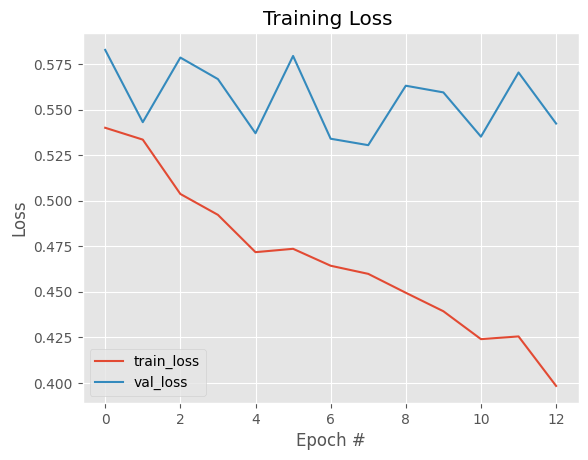

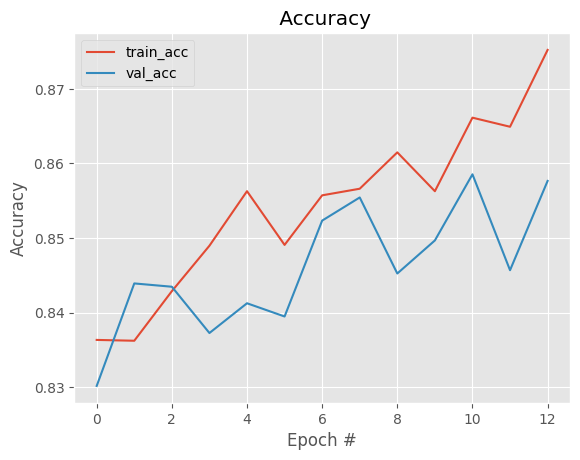

In [17]:
save_plot_loss(hist_effM_big, "dl_adam_1e_2_loss")
save_plot_acc(hist_effM_big,  "dl_adam_1e_2_acc")


In [18]:
inputs = base_model_M.input
x = img_augmentation(inputs)

x = base_model_M(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)


outputs =tf.keras.layers.Dense(55, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()



model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, 
                                           momentum=0.1,
                                           weight_decay=1e-5,
                                           use_ema=True),  
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)
    

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                           

In [19]:
start = time.time()

epochs=100



hist_effM_big = model.fit(train_data_big, epochs=epochs, validation_data=val_data_big, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint])

end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Epoch 1/100
282/282 [==============================] - 107s 312ms/step - loss: 1.9768 - accuracy: 0.5059 - val_loss: 1.1255 - val_accuracy: 0.6851
Epoch 2/100
282/282 [==============================] - 85s 298ms/step - loss: 1.3740 - accuracy: 0.6249 - val_loss: 0.9532 - val_accuracy: 0.7290
Epoch 3/100
282/282 [==============================] - 85s 297ms/step - loss: 1.1843 - accuracy: 0.6697 - val_loss: 0.8524 - val_accuracy: 0.7610
Epoch 4/100
282/282 [==============================] - 85s 299ms/step - loss: 1.0658 - accuracy: 0.6978 - val_loss: 0.7713 - val_accuracy: 0.7774
Epoch 5/100
282/282 [==============================] - 85s 297ms/step - loss: 0.9786 - accuracy: 0.7203 - val_loss: 0.7336 - val_accuracy: 0.7858
Epoch 6/100
282/282 [==============================] - 88s 310ms/step - loss: 0.9249 - accuracy: 0.7318 - val_loss: 0.7315 - val_accuracy: 0.7885
Epoch 7/100
282/282 [==============================] - 89s 311ms/step - loss: 0.8819 - accuracy: 0.7428 - val_loss: 0.6661 

min val_loss:  0.5675439238548279
max val_accuracy:  0.8368070721626282


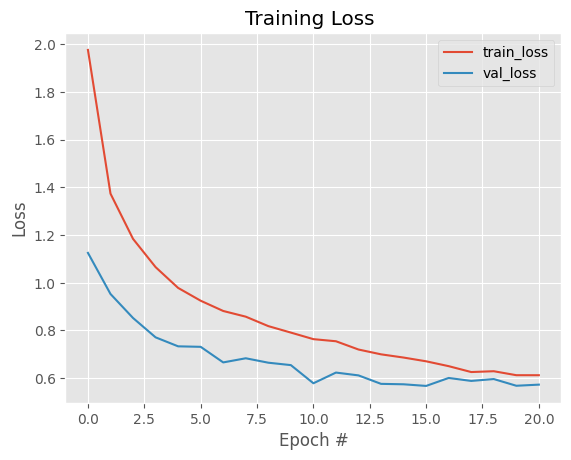

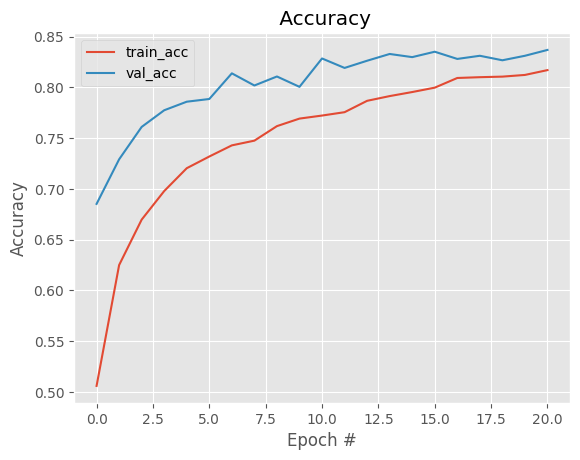

In [21]:
save_plot_loss(hist_effM_big, "dl_adam_1e_2_loss")
save_plot_acc(hist_effM_big,  "dl_adam_1e_2_acc")


In [20]:
inputs = base_model_M.input
x = img_augmentation(inputs)

x = base_model_M(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x) 


outputs =tf.keras.layers.Dense(55, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),  
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)


    

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 512)               655872    
                                                           

In [22]:
start = time.time()

epochs=100



hist_effM_big = model.fit(train_data_big, epochs=epochs, validation_data=val_data_big, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint])

end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Epoch 1/100
282/282 [==============================] - 105s 310ms/step - loss: 2.0153 - accuracy: 0.4839 - val_loss: 0.9724 - val_accuracy: 0.7251
Epoch 2/100
282/282 [==============================] - 85s 297ms/step - loss: 1.2939 - accuracy: 0.6391 - val_loss: 0.7814 - val_accuracy: 0.7778
Epoch 3/100
282/282 [==============================] - 88s 309ms/step - loss: 1.1265 - accuracy: 0.6812 - val_loss: 0.7404 - val_accuracy: 0.7836
Epoch 4/100
282/282 [==============================] - 85s 297ms/step - loss: 1.0240 - accuracy: 0.7025 - val_loss: 0.6738 - val_accuracy: 0.8027
Epoch 5/100
282/282 [==============================] - 85s 297ms/step - loss: 0.9701 - accuracy: 0.7195 - val_loss: 0.6171 - val_accuracy: 0.8217
Epoch 6/100
282/282 [==============================] - 85s 297ms/step - loss: 0.9189 - accuracy: 0.7305 - val_loss: 0.6209 - val_accuracy: 0.8164
Epoch 7/100
282/282 [==============================] - 85s 298ms/step - loss: 0.8705 - accuracy: 0.7427 - val_loss: 0.6191 

min val_loss:  0.5347410440444946
max val_accuracy:  0.850554347038269


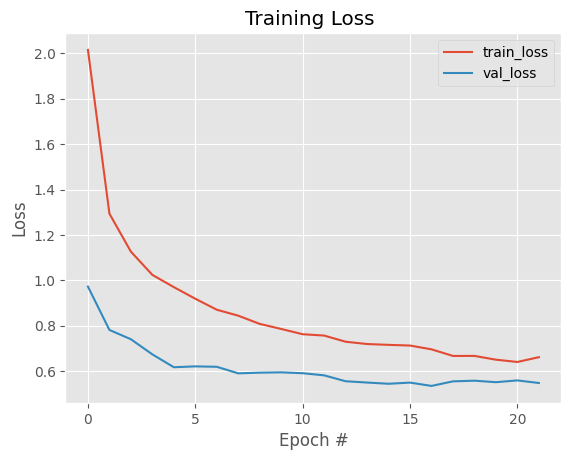

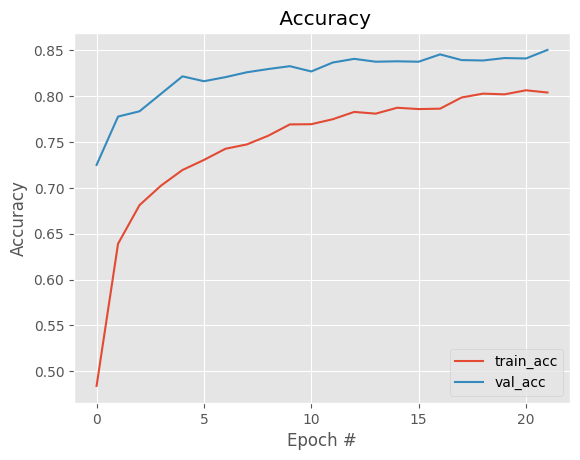

In [23]:
save_plot_loss(hist_effM_big, "dl_adam_1e_2_loss")
save_plot_acc(hist_effM_big,  "dl_adam_1e_2_acc")


In [24]:
inputs = base_model_M.input
x = img_augmentation(inputs)

x = base_model_M(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(units=1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x) 


outputs =tf.keras.layers.Dense(55, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),  
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)


    

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 1024)              1311744   
                                                           

In [25]:
start = time.time()

epochs=100



hist_effM_big = model.fit(train_data_big, epochs=epochs, validation_data=val_data_big, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint])

end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Epoch 1/100
282/282 [==============================] - 107s 309ms/step - loss: 1.8395 - accuracy: 0.5224 - val_loss: 0.9370 - val_accuracy: 0.7326
Epoch 2/100
282/282 [==============================] - 85s 296ms/step - loss: 1.1697 - accuracy: 0.6647 - val_loss: 0.7656 - val_accuracy: 0.7800
Epoch 3/100
282/282 [==============================] - 85s 299ms/step - loss: 1.0483 - accuracy: 0.6922 - val_loss: 0.6925 - val_accuracy: 0.7982
Epoch 4/100
282/282 [==============================] - 85s 297ms/step - loss: 0.9568 - accuracy: 0.7200 - val_loss: 0.6646 - val_accuracy: 0.8102
Epoch 5/100
282/282 [==============================] - 85s 297ms/step - loss: 0.8910 - accuracy: 0.7374 - val_loss: 0.6523 - val_accuracy: 0.8111
Epoch 6/100
282/282 [==============================] - 85s 296ms/step - loss: 0.8481 - accuracy: 0.7559 - val_loss: 0.6290 - val_accuracy: 0.8208
Epoch 7/100
282/282 [==============================] - 85s 297ms/step - loss: 0.7927 - accuracy: 0.7663 - val_loss: 0.6295 

min val_loss:  0.5660001039505005
max val_accuracy:  0.8465632200241089


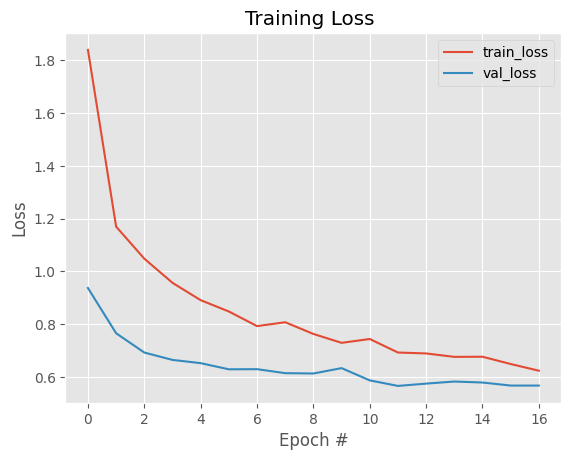

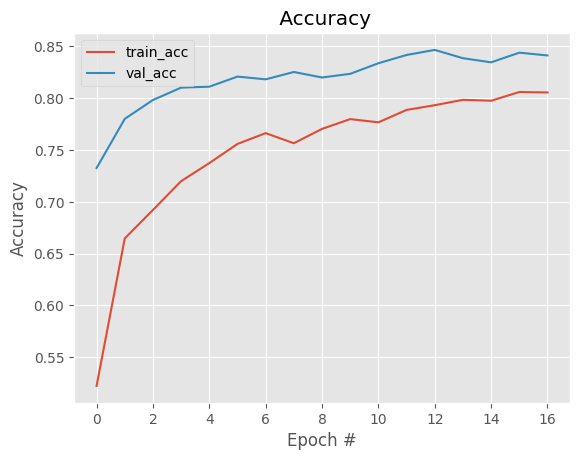

In [26]:
save_plot_loss(hist_effM_big, "dl_adam_1e_2_loss")
save_plot_acc(hist_effM_big,  "dl_adam_1e_2_acc")


In [27]:
inputs = base_model_M.input
x = img_augmentation(inputs)

x = base_model_M(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs =tf.keras.layers.Dense(55, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),  
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)


    

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_6  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 55)                70455     
                                                           

In [28]:
start = time.time()

epochs=100



hist_effM_big = model.fit(train_data_big, epochs=epochs, validation_data=val_data_big, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint])

end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Epoch 1/100
282/282 [==============================] - 107s 312ms/step - loss: 2.2885 - accuracy: 0.4902 - val_loss: 1.3160 - val_accuracy: 0.6785
Epoch 2/100
282/282 [==============================] - 89s 312ms/step - loss: 1.3566 - accuracy: 0.6673 - val_loss: 0.9970 - val_accuracy: 0.7370
Epoch 3/100
282/282 [==============================] - 85s 297ms/step - loss: 1.1345 - accuracy: 0.7120 - val_loss: 0.8671 - val_accuracy: 0.7712
Epoch 4/100
282/282 [==============================] - 85s 297ms/step - loss: 1.0108 - accuracy: 0.7414 - val_loss: 0.8020 - val_accuracy: 0.7814
Epoch 5/100
282/282 [==============================] - 85s 298ms/step - loss: 0.9318 - accuracy: 0.7488 - val_loss: 0.7542 - val_accuracy: 0.8053
Epoch 6/100
282/282 [==============================] - 84s 296ms/step - loss: 0.8710 - accuracy: 0.7681 - val_loss: 0.7181 - val_accuracy: 0.8044
Epoch 7/100
282/282 [==============================] - 85s 299ms/step - loss: 0.8303 - accuracy: 0.7787 - val_loss: 0.6946 

KeyboardInterrupt: 

min val_loss:  0.5660001039505005
max val_accuracy:  0.8465632200241089


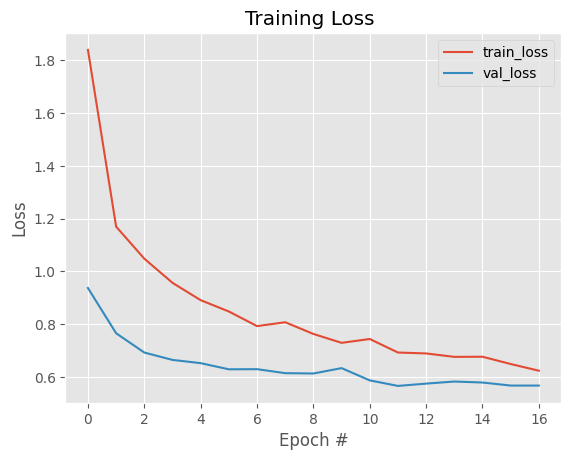

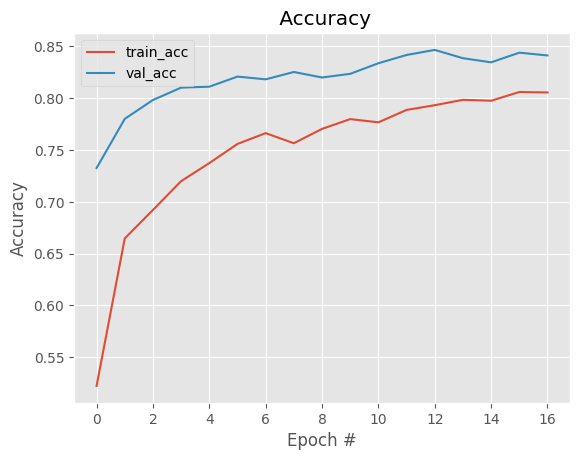

In [29]:
save_plot_loss(hist_effM_big, "dl_loss")
save_plot_acc(hist_effM_big,  "dl_acc")


In [30]:
inputs = base_model_M.input
x = img_augmentation(inputs)

x = base_model_M(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) 

outputs =tf.keras.layers.Dense(55, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),  
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)


    

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 img_augmentation (Sequenti  (None, None, None, 3)     0         
 al)                                                             
                                                                 
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d_7  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                           

In [31]:
start = time.time()

epochs=100



hist_effM_big = model.fit(train_data_big, epochs=epochs, validation_data=val_data_big, verbose=1, callbacks=[cbEvalAcc, cbCheckpoint])

end = time.time()
print("The time of execution of above program is :",
      (end-start), "s")

Epoch 1/100
282/282 [==============================] - 109s 325ms/step - loss: 2.3851 - accuracy: 0.4704 - val_loss: 1.3838 - val_accuracy: 0.6537
Epoch 2/100
282/282 [==============================] - 85s 297ms/step - loss: 1.4458 - accuracy: 0.6476 - val_loss: 1.0423 - val_accuracy: 0.7361
Epoch 3/100
282/282 [==============================] - 85s 298ms/step - loss: 1.2043 - accuracy: 0.6925 - val_loss: 0.8970 - val_accuracy: 0.7667
Epoch 4/100
282/282 [==============================] - 85s 296ms/step - loss: 1.0743 - accuracy: 0.7201 - val_loss: 0.8391 - val_accuracy: 0.7707
Epoch 5/100
282/282 [==============================] - 85s 297ms/step - loss: 1.0060 - accuracy: 0.7305 - val_loss: 0.7787 - val_accuracy: 0.7902
Epoch 6/100
282/282 [==============================] - 89s 311ms/step - loss: 0.9437 - accuracy: 0.7510 - val_loss: 0.7491 - val_accuracy: 0.7982
Epoch 7/100
282/282 [==============================] - 84s 295ms/step - loss: 0.8889 - accuracy: 0.7635 - val_loss: 0.7082 

min val_loss:  0.5314905643463135
max val_accuracy:  0.8580931425094604


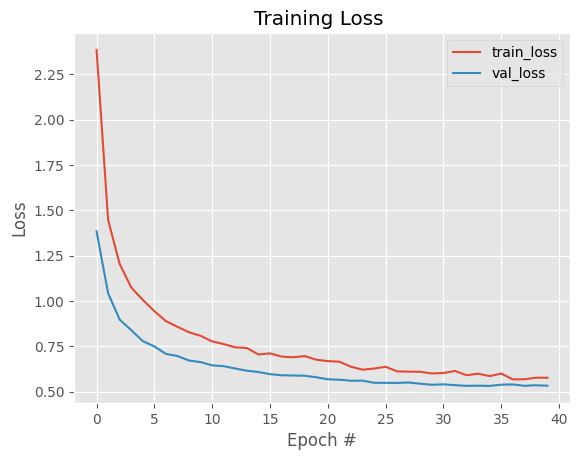

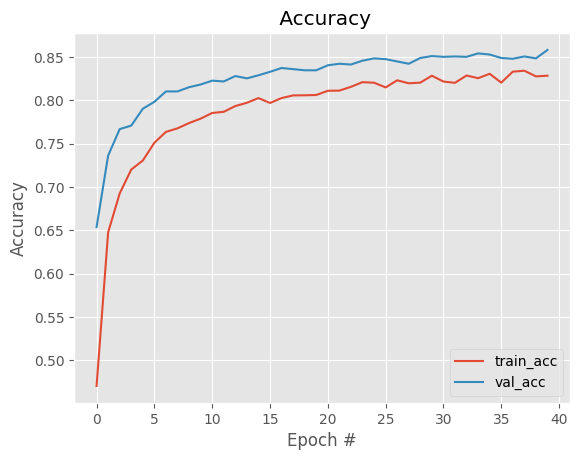

In [32]:
save_plot_loss(hist_effM_big, "dl_loss")
save_plot_acc(hist_effM_big,  "dl_acc")


In [33]:
model.save("best_model_85.keras")

# Evaluate

In [46]:
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.preprocessing import image
import seaborn as sns
img_width, img_height = 299, 299

def labels_confusion_matrix():
    folder_path="./test_data"
    food_map = {}
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        food_map[i] = j 
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        print("true: ", true)
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):
            
            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(320, 320))
            
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            prediction = model.predict(img_processed)
            
            index = np.argmax(prediction[0])
            
            print("index: ", food_map[index])
            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):

    cmap="viridis"
    cm_plot_labels = [i for i in range(55)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.1)
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm, annot=True,cmap=cmap) 

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [47]:
y_true,y_pred=labels_confusion_matrix()

true:  donat
1/1 [==============================] - 1s 555ms/step
index:  donat
1/1 [==============================] - 0s 41ms/step
index:  donat
1/1 [==============================] - 0s 41ms/step
index:  donat
1/1 [==============================] - 0s 41ms/step
index:  donat
1/1 [==============================] - 0s 41ms/step
index:  donat
1/1 [==============================] - 0s 45ms/step
index:  donat
1/1 [==============================] - 0s 41ms/step
index:  donat
1/1 [==============================] - 0s 43ms/step
index:  donat
1/1 [==============================] - 0s 42ms/step
index:  donat
1/1 [==============================] - 0s 41ms/step
index:  donat
1/1 [==============================] - 0s 41ms/step
index:  donat
1/1 [==============================] - 0s 41ms/step
index:  donat
1/1 [==============================] - 0s 45ms/step
index:  donat
true:  pempek
1/1 [==============================] - 0s 45ms/step
index:  pempek
1/1 [==============================] - 0s 46ms/

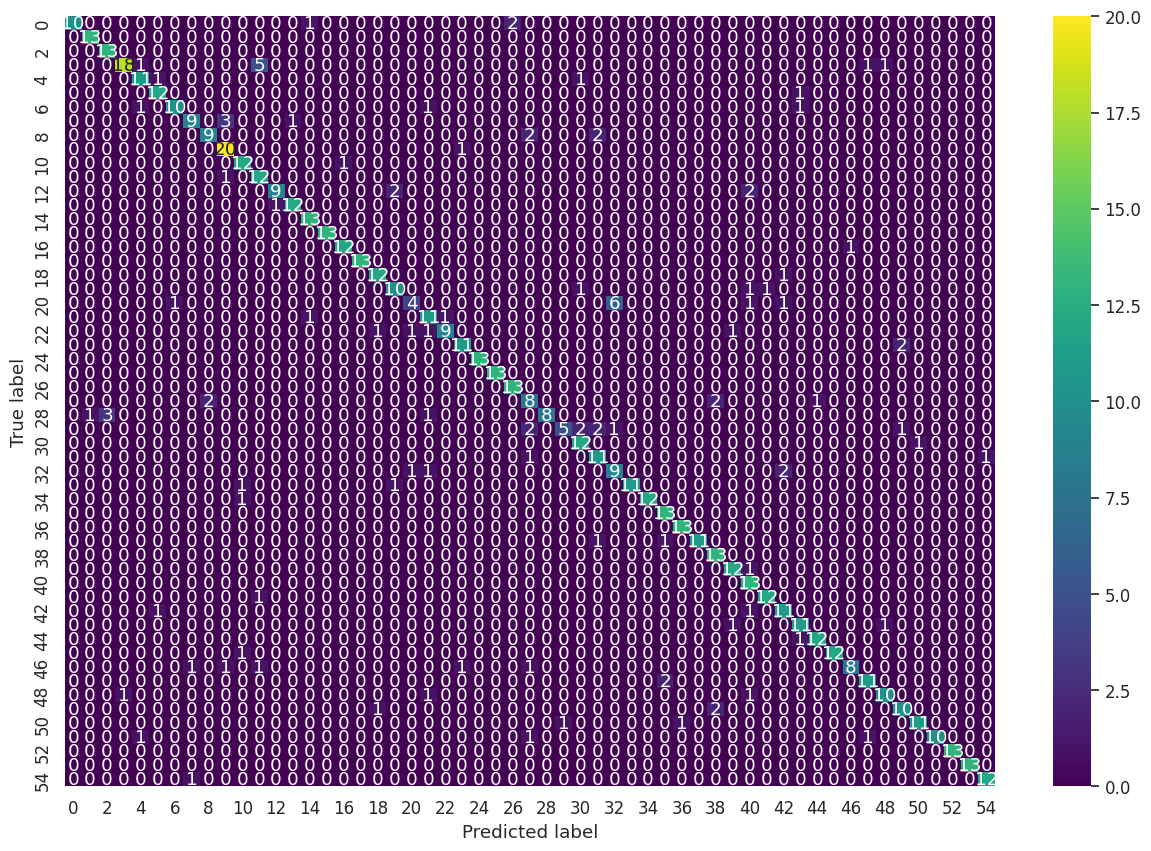

In [50]:
print_confusion_matrix(y_true,y_pred)

In [48]:
allfoodNameDF =   pd.read_csv("all_food_names.csv")

foodLabels = allfoodNameDF.values.tolist()


2024-09-27 16:41:50.476290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-09-27 16:41:50.476360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-09-27 16:41:51.165443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1/1 [==============================] - 0s 124ms/step


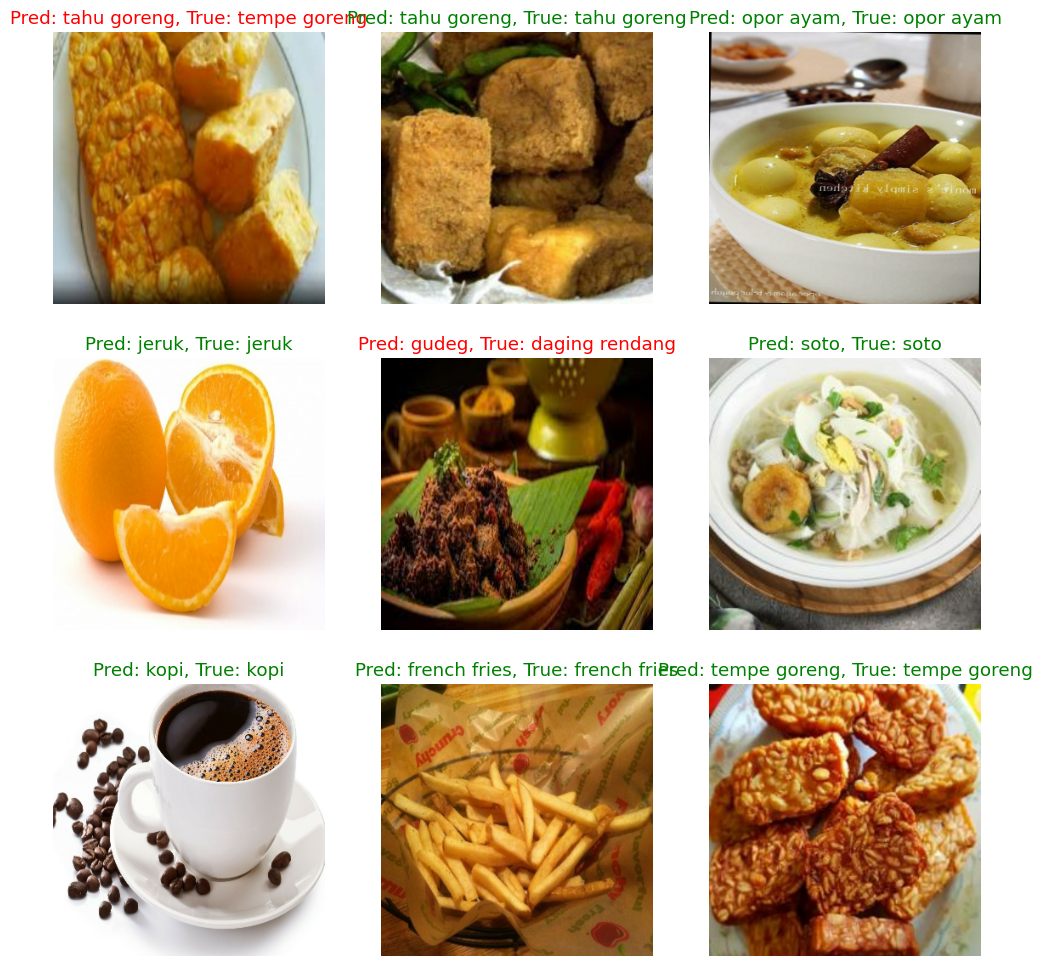

In [52]:
test_data = test_data_big.shuffle(buffer_size=1000)

for images, labels in test_data.take(1):
    # Melakukan prediksi
    predictions = model.predict(images)
    
    # Mengambil kelas prediksi dan true label
    predicted_labels = tf.argmax(predictions, axis=1)
    true_labels = tf.argmax(labels, axis=1)
    color = ""
    
    

    # Menampilkan beberapa gambar, hasil prediksi, dan true label
    plt.figure(figsize=(12, 12))
    for i in range(9):  # Menampilkan 9 gambar pertama
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if foodLabels[predicted_labels[i]][1] ==  foodLabels[true_labels[i]][1]:
            color = "green"
        else:
            color = "red"
        plt.title(f"Pred: {foodLabels[predicted_labels[i]][1]}, True: {foodLabels[true_labels[i]][1]}" , color=color)
        plt.axis("off")

    plt.show()


In [ ]:
model.evaluate(test_data_big)

In [5]:
model_from_disk = tf.keras.models.load_model('best_model_86.keras')

In [6]:
model_from_disk.evaluate(test_data_big)

2024-10-16 04:46:55.576956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-10-16 04:46:55.577037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2024-10-16 04:46:55.979266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-10-16 04:46:59.697258: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


23/23 [==============================] - 27s 392ms/step - loss: 0.4948 - accuracy: 0.8569


[0.4948447346687317, 0.8569482564926147]

In [7]:
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.preprocessing import image
import seaborn as sns
img_width, img_height = 299, 299

def labels_confusion_matrix():
    folder_path="./test_data"
    food_map = {}
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        food_map[i] = j 
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        print("true: ", true)
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):
            
            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(320, 320))
            
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            prediction = model_from_disk.predict(img_processed)
            
            index = np.argmax(prediction[0])
            
            print("index: ", food_map[index])
            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):

    cmap="viridis"
    cm_plot_labels = [i for i in range(55)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.1)
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm, annot=True,cmap=cmap) 

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [8]:
y_true,y_pred= labels_confusion_matrix()

true:  donat
1/1 [==============================] - 6s 6s/step
index:  donat
1/1 [==============================] - 0s 58ms/step
index:  donat
1/1 [==============================] - 0s 52ms/step
index:  donat
1/1 [==============================] - 0s 46ms/step
index:  donat
1/1 [==============================] - 0s 45ms/step
index:  donat
1/1 [==============================] - 0s 47ms/step
index:  donat
1/1 [==============================] - 0s 46ms/step
index:  donat
1/1 [==============================] - 0s 56ms/step
index:  donat
1/1 [==============================] - 0s 52ms/step
index:  donat
1/1 [==============================] - 0s 50ms/step
index:  donat
1/1 [==============================] - 0s 51ms/step
index:  donat
1/1 [==============================] - 0s 48ms/step
index:  donat
1/1 [==============================] - 0s 48ms/step
index:  donat
true:  pempek
1/1 [==============================] - 0s 51ms/step
index:  pempek
1/1 [==============================] - 0s 48ms/ste

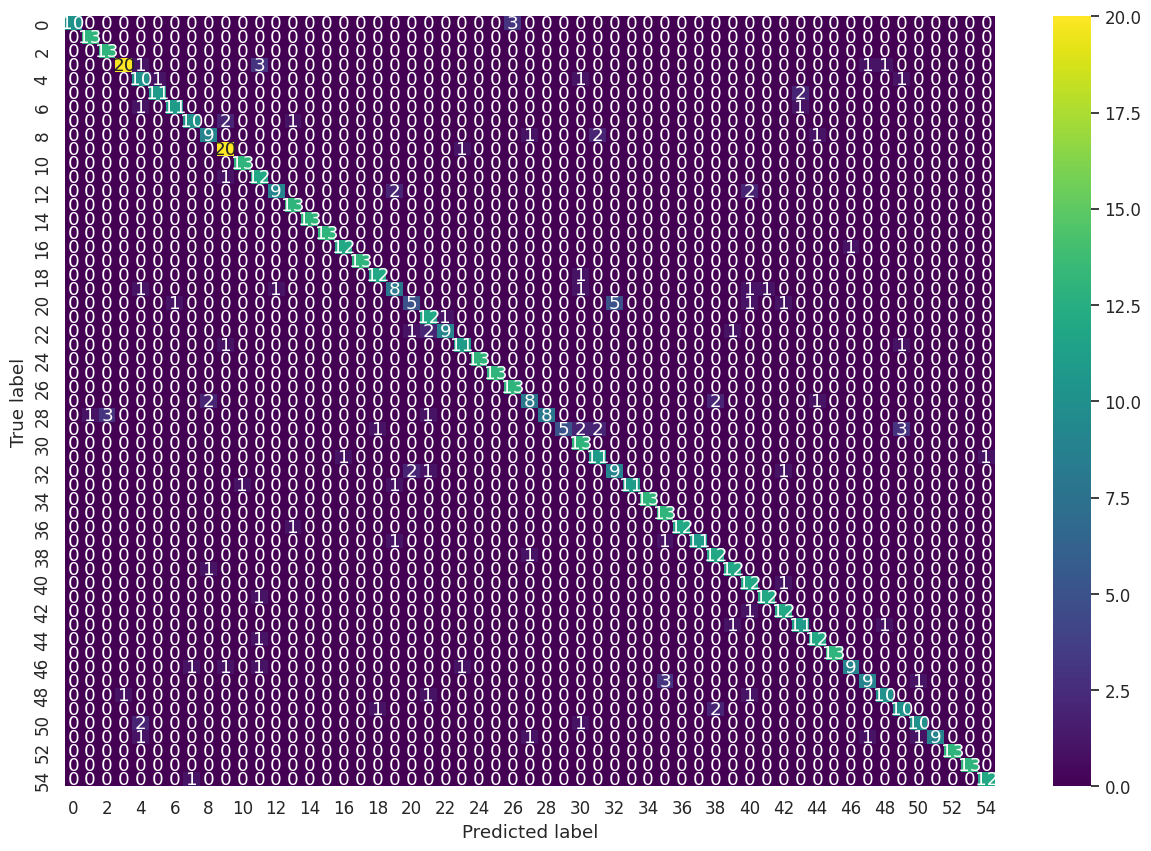

In [9]:
print_confusion_matrix(y_true,y_pred)

In [10]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.93      1.00      0.96        13
           2       0.81      1.00      0.90        13
           3       0.95      0.77      0.85        26
           4       0.62      0.77      0.69        13
           5       0.92      0.85      0.88        13
           6       0.92      0.85      0.88        13
           7       0.83      0.77      0.80        13
           8       0.75      0.69      0.72        13
           9       0.80      0.95      0.87        21
          10       0.93      1.00      0.96        13
          11       0.67      0.92      0.77        13
          12       0.90      0.69      0.78        13
          13       0.87      1.00      0.93        13
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00        13
          16       0.92      0.92      0.92        13
          17       1.00    